## Imports

In [1]:
import bilby
import gwpopulation as gwpop
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import corner
import seaborn as sns

from astropy import cosmology, units
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

from bilby.core.prior import Uniform, Constraint, PriorDict, LogUniform
from bilby.gw.prior import BBHPriorDict
from gwpopulation.models import mass, spin

xp = gwpop.cupy_utils.xp

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(xp)

<module 'cupy' from '/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/cupy/__init__.py'>


# Model B - Gaussian

This paper uses `Overall_posterior`.

In [3]:
parameter_translator = dict(
    mass_1_det = 'm1_detector_frame_Msun',
    mass_2_det = 'm2_detector_frame_Msun',
    luminosity_distance = 'luminosity_distance_Mpc',
    a_1 = 'spin1',
    a_2 = 'spin2',
    cos_tilt_1 = 'costilt1',
    cos_tilt_2 = 'costilt2')

In [4]:
file = 'GWTC-1_sample_release/GW{}_GWTC-1.hdf5'

events = ['150914', '151012', '151226', '170104', '170608', '170729', '170809', '170814', 
          '170818', '170823']

posteriorsB = []
priorsB = []
event_name = []

for event in events:
    _posterior = pd.DataFrame()
    _prior = pd.DataFrame()
    with h5py.File(file.format(event), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff['Overall_posterior'][gwtc_key]
    posteriorsB.append(_posterior)
    event_name.append(event)

In [5]:
luminosity_distances = np.linspace(1, 10000, 1000)
redshifts = np.array([cosmology.z_at_value(cosmology.Planck15.luminosity_distance, 
                                                   dl * units.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)

In [6]:
for posterior in posteriorsB:
    posterior['redshift'] = dl_to_z(posterior['luminosity_distance'])
    posterior['mass_1'] = posterior['mass_1_det'] / (1 + posterior['redshift'])
    posterior['mass_2'] = posterior['mass_2_det'] / (1 + posterior['redshift'])
    posterior['mass_ratio'] = posterior['mass_2'] / posterior['mass_1']

### Sampling effective spins ($\chi_{\mathrm{eff}}$) by parameter estimation

$$\chi_{\mathrm{eff}} = \frac{a_1 cost_1 + a_2 q cost_2}{1 + q}$$

For each gravitational wave we obtain a set of discrete samples p($\chi_{\mathrm{eff}}$|data) (given by `posterior['chieff']` here)

Effective spins are drawn from a simple truncated Gaussian.

### Sampling effective precession spin ($\chi_{\mathrm{p}}$) by parameter estimation

$$\chi_{\mathrm{p}} = max \bigg[a_1sint_1 , \bigg(\frac{4q + 3}{4 + 3q}\bigg)q a_2sint_2\bigg]$$


$q = \frac{m_2}{m_1}$

In [7]:
def chieff(a1, a2, q, cost1, cost2):
    chi_eff = (a1*cost1 + a2*q*cost2)/(1+q)
    return chi_eff

def chiP(a1, a2, q, cost1, cost2):
    q1 = a1 * sin(arccos(cost1))
    q2 = ((4*q + 3)/(4 + 3*q)) * q * a2 * sin(arccos(cost2))
    return np.max([q1, q2])

In [8]:
for posterior in posteriorsB:
    posterior['chi_eff'] = chieff(posterior['a_1'], posterior['a_2'], posterior['mass_ratio'],
                                  posterior['cos_tilt_1'], posterior['cos_tilt_2'])
    posterior['chi_p'] = chiP(posterior['a_1'], posterior['a_2'],
                              posterior['mass_ratio'], posterior['cos_tilt_1'], posterior['cos_tilt_2'])

In [9]:
posteriorsB[0]

,mass_1_det,mass_2_det,luminosity_distance,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_1,mass_2,mass_ratio,chi_eff,chi_p
0,40.823686,26.440697,429.439630,0.720602,0.536915,-0.591917,0.188768,0.090895,37.422188,24.237614,0.647680,-0.219031,0.984303
1,34.626875,34.212308,337.154490,0.238156,0.410068,-0.076179,-0.517005,0.072273,32.292953,31.906329,0.988028,-0.114491,0.984303
2,36.142271,33.174642,487.316326,0.297883,0.187064,-0.335351,-0.821574,0.102359,32.786286,30.094216,0.917890,-0.125640,0.984303
3,41.569619,31.876132,488.540224,0.347413,0.059700,0.109706,-0.500742,0.102600,37.701443,28.909964,0.766813,0.008597,0.984303
4,37.869125,33.759950,463.788715,0.147665,0.086681,-0.761297,0.988754,0.097718,34.498038,30.754659,0.891490,-0.019038,0.984303
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,40.383795,31.959753,460.559361,0.088515,0.577331,0.870492,-0.264759,0.097079,36.810276,29.131669,0.791400,-0.024515,0.984303
8346,38.164225,35.639218,449.985818,0.122339,0.190940,0.783595,0.267030,0.094983,34.853703,32.547725,0.933838,0.074193,0.984303
8347,37.670359,34.004716,513.756334,0.439794,0.470269,-0.208949,0.113237,0.107545,34.012487,30.702786,0.902692,-0.023033,0.984303
8348,36.746741,35.672009,399.113830,0.163340,0.423884,0.160240,0.171165,0.084824,33.873472,32.882775,0.970753,0.049020,0.984303


Here, simulating the LALprior for $\chi_{\mathrm{eff}}$:

In [10]:
simulated_LALprior = BBHPriorDict()

# mass -- these are detector frame masses
simulated_LALprior["mass_1"] = Uniform(minimum = 0, maximum = 1, latex_label = 'm1')
simulated_LALprior["mass_2"] = Uniform(minimum = 0, maximum = 1, latex_label = 'm2')
simulated_LALprior["mass_ratio"] = Constraint(minimum = 0, maximum = 1)

# spin
simulated_LALprior["a_1"] = Uniform(minimum = 0, maximum = 1, latex_label = 'a1')
simulated_LALprior["a_2"] = Uniform(minimum = 0, maximum = 1, latex_label = 'a2')
simulated_LALprior["cos_tilt_1"] = Uniform(minimum = -1, maximum = 1, latex_label = 'cost1')
simulated_LALprior["cos_tilt_2"] = Uniform(minimum = -1, maximum = 1, latex_label = 'cost2')

21:08 bilby INFO    : No prior given, using default BBH priors in /home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [11]:
del simulated_LALprior["chirp_mass"]

In [12]:
simulated_LALprior_samples = simulated_LALprior.sample(100000)

In [13]:
simulated_LALprior_samples = pd.DataFrame(simulated_LALprior_samples)
simulated_LALprior_samples["mass_ratio"] = simulated_LALprior_samples["mass_2"]/simulated_LALprior_samples["mass_1"]
simulated_LALprior_samples 

,mass_1,mass_2,luminosity_distance,dec,ra,theta_jn,psi,phase,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,cos_tilt_1,cos_tilt_2,mass_ratio
0,0.950079,0.701466,4689.089487,0.081148,1.197446,2.996967,0.207457,1.208921,0.344980,0.321974,1.509880,1.115525,6.039174,0.449851,-0.779320,0.808178,0.738324
1,0.323463,0.154500,4607.311610,-0.139463,5.625822,2.459460,2.979637,4.479693,0.880815,0.948277,2.708317,2.493246,2.973768,4.294076,0.113163,0.791876,0.477644
2,0.743647,0.471976,3799.197013,-0.371309,4.459670,0.140931,2.271942,1.358859,0.914842,0.787778,1.292247,1.313930,3.059391,4.698431,-0.987423,-0.933857,0.634678
3,0.934393,0.273282,4014.247669,0.577615,6.220614,1.542368,2.709524,3.810465,0.752124,0.322351,1.469485,2.174308,0.699531,2.983117,0.276982,0.577729,0.292470
4,0.669778,0.380313,3766.457646,-0.684574,4.781919,2.620424,2.400079,4.635570,0.396396,0.538427,0.539315,1.787313,2.511514,5.094862,-0.020785,-0.380077,0.567819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.805084,0.688821,4623.834895,-1.233986,3.715961,2.066858,2.365715,1.618979,0.538114,0.421734,1.687714,1.695105,4.413301,3.421710,0.263680,-0.355683,0.855589
99996,0.789699,0.405945,2136.803326,-0.671542,5.014503,0.869351,1.330423,1.105019,0.833688,0.029060,0.846091,1.316572,3.542774,4.991360,-0.200146,-0.210748,0.514050
99997,0.867681,0.563337,3487.252235,-1.022131,4.089540,2.939863,0.796326,1.236799,0.934243,0.205631,1.523335,2.199838,2.928171,5.471237,0.736877,0.764611,0.649245
99998,0.396147,0.207895,2458.874722,0.299221,5.030888,0.859096,1.341225,0.343435,0.533457,0.229192,0.882748,1.442214,0.883444,5.262815,-0.621535,0.261623,0.524793


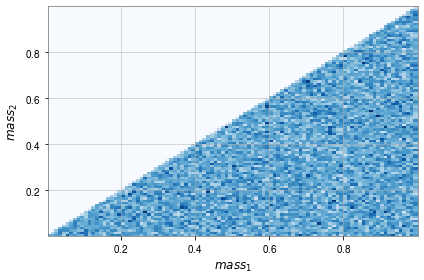

In [15]:
plt.hist2d(simulated_LALprior_samples['mass_1'], simulated_LALprior_samples['mass_2'], bins=100, cmap='Blues')
plt.xlabel('$mass_1$')
plt.ylabel('$mass_2$')
plt.tight_layout()
plt.show()
plt.close()

In [16]:
simulated_LALprior_samples["chi_eff"] = chieff(simulated_LALprior_samples["a_1"], 
                                               simulated_LALprior_samples["a_2"], 
                                               simulated_LALprior_samples["mass_ratio"],
                                               simulated_LALprior_samples["cos_tilt_1"], 
                                               simulated_LALprior_samples["cos_tilt_2"])

simulated_LALprior_samples['chi_p'] = chiP(simulated_LALprior_samples['a_1'], 
                                           simulated_LALprior_samples['a_2'],
                                           simulated_LALprior_samples['mass_ratio'],
                                           simulated_LALprior_samples['cos_tilt_1'],
                                           simulated_LALprior_samples['cos_tilt_2'])

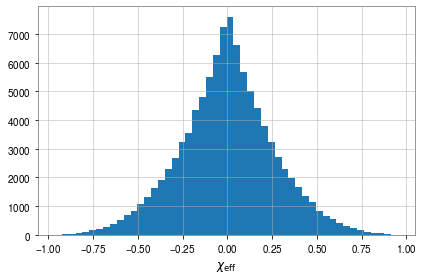

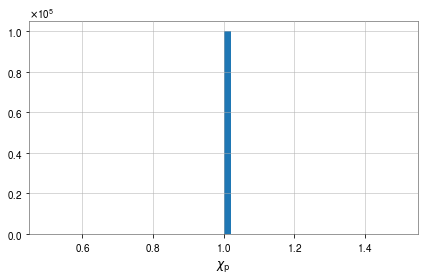

In [22]:
plt.hist(simulated_LALprior_samples['chi_eff'], bins = 50)
plt.xlabel('$\\chi_{\mathrm{eff}}$')
plt.tight_layout()
plt.show()
plt.close()

plt.hist(simulated_LALprior_samples['chi_p'], bins = 50)
plt.xlabel('$\\chi_{\mathrm{p}}$')
plt.tight_layout()
plt.show()
plt.close()

<AxesSubplot:xlabel='chi_eff'>

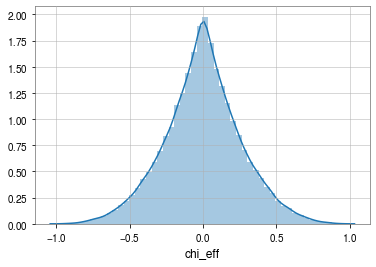

In [18]:
sns.distplot(simulated_LALprior_samples['chi_eff'], bins=50)

<AxesSubplot:xlabel='chi_p'>

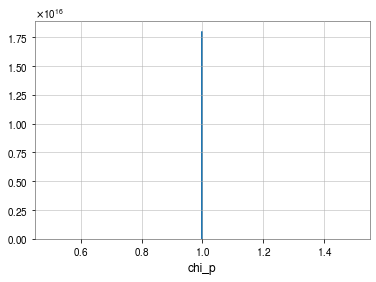

In [19]:
sns.distplot(simulated_LALprior_samples['chi_p'], bins=50)

Good place to know about KDE https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

Here I just go with the SciPy Gaussian KDE.

In [30]:
from scipy.stats import gaussian_kde

simulated_LAL_chi_prior = gaussian_kde(simulated_LALprior_samples["chi_eff"])

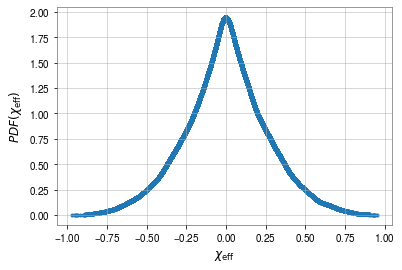

In [31]:
plt.plot(simulated_LALprior_samples["chi_eff"], 
         simulated_LAL_chi_prior(simulated_LALprior_samples["chi_eff"]), '.')
plt.xlabel("$\\chi_{\mathrm{eff}}$")
plt.ylabel("$PDF(\\chi_{\mathrm{eff}})$")
plt.show()

To put it in terms of the notation given <a href = "https://arxiv.org/pdf/2001.06051.pdf">here</a>, this PDF given above is $p_{pe}$($\chi_{\mathrm{eff,j}}$). Now we need to reweight it with $p_{pe}$($m_{1,j}, m_{2,j}, z_j$)

$$p_{pe}(m_1, m_2, z) \propto (1+z)^2 D_L(z)^2  \bigg[ D_c(z) + \frac{c(1+z)}{H(z)}\bigg]$$

To calculate Hubble Parameter https://docs.astropy.org/en/stable/_modules/astropy/cosmology/core.html

In [19]:
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
import astropy

def LALprior_wt(z, chi_eff):
    d_l = cosmo.luminosity_distance(z).to(u.Mpc).value
    d_c = cosmo.comoving_distance(z).to(u.Mpc).value
    h_z = cosmo.efunc(z) * cosmo.H(0).value
    c = astropy.constants.c.to('km/s').value
    weight = (1+z)**2 * d_l**2 * (d_c + (c * (1+z)) / h_z)
    return weight * simulated_LAL_chi_prior(chi_eff)

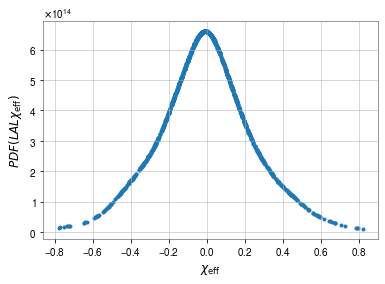

In [20]:
lal = LALprior_wt(4, simulated_LALprior_samples["chi_eff"])
plt.plot(simulated_LALprior_samples["chi_eff"], lal, '.')
plt.xlabel("$\\chi_{\mathrm{eff}}$")
plt.ylabel("$PDF(LAL\\chi_{\mathrm{eff}})$")
plt.show()

Next we need $p$($\chi_{\mathrm{eff}, j} | \mu, \sigma^2 $) and reweight it with $p_{astro}$($m_{1,j}, m_{2,j}, z_j$)

$$p_{astro}(m_1, m_2, z) \propto \frac{(1+z)^{1.7}}{m_1 (m_1 - M_{min})} \frac{dV_c}{dz}$$

To calculate $\frac{dV_c}{dz}$ :  https://docs.astropy.org/en/stable/_modules/astropy/cosmology/core.html

In [21]:
def astro_prior_wt(m1, z):
    mmin = 5
    dVc_dz = cosmo.differential_comoving_volume(z).to(u.Mpc**3/u.sr).value * 4 * pi
    weight = (1+z)**1.7 / (m1 * (m1 - mmin)) * dVc_dz
    return weight

In [22]:
for posterior in posteriorsB:
    posterior["LALprior"] = LALprior_wt(posterior["redshift"], posterior["chi_eff"]) 
    posterior["astro_prior"] = astro_prior_wt(posterior["mass_1"], posterior["redshift"])
    posterior["prior"] = posterior["astro_prior"] / posterior["LALprior"]

In [23]:
posteriorsB[0]

,mass_1_det,mass_2_det,luminosity_distance,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_1,mass_2,mass_ratio,chi_eff,LALprior,astro_prior,prior
0,40.823686,26.440697,429.439630,0.720602,0.536915,-0.591917,0.188768,0.090895,37.422188,24.237614,0.647680,-0.219031,1.090058e+09,7.880192e+06,0.007229
1,34.626875,34.212308,337.154490,0.238156,0.410068,-0.076179,-0.517005,0.072273,32.292953,31.906329,0.988028,-0.114491,9.455759e+08,6.784153e+06,0.007175
2,36.142271,33.174642,487.316326,0.297883,0.187064,-0.335351,-0.821574,0.102359,32.786286,30.094216,0.917890,-0.125640,2.090279e+09,1.339410e+07,0.006408
3,41.569619,31.876132,488.540224,0.347413,0.059700,0.109706,-0.500742,0.102600,37.701443,28.909964,0.766813,0.008597,2.647661e+09,9.945097e+06,0.003756
4,37.869125,33.759950,463.788715,0.147665,0.086681,-0.761297,0.988754,0.097718,34.498038,30.754659,0.891490,-0.019038,2.361129e+09,1.090043e+07,0.004617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,40.383795,31.959753,460.559361,0.088515,0.577331,0.870492,-0.264759,0.097079,36.810276,29.131669,0.791400,-0.024515,2.316641e+09,9.346400e+06,0.004034
8346,38.164225,35.639218,449.985818,0.122339,0.190940,0.783595,0.267030,0.094983,34.853703,32.547725,0.933838,0.074193,1.929859e+09,1.005704e+07,0.005211
8347,37.670359,34.004716,513.756334,0.439794,0.470269,-0.208949,0.113237,0.107545,34.012487,30.702786,0.902692,-0.023033,2.977712e+09,1.368816e+07,0.004597
8348,36.746741,35.672009,399.113830,0.163340,0.423884,0.160240,0.171165,0.084824,33.873472,32.882775,0.970753,0.049020,1.572236e+09,8.483864e+06,0.005396


<AxesSubplot:xlabel='prior'>

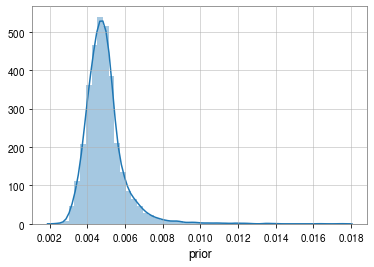

In [24]:
sns.distplot(posteriorsB[0]["prior"], bins = 50)

## Hyper-prior model

### $\chi_{\mathrm{eff}}$ 

Effective spins are drawn from a simple truncated Gaussian.

In [25]:
# from scipy.special import erf

# def truncated_gaussian(dataset, mu, var):
#     norm = (2/(xp.pi*var))**0.5 * (erf((1-mu)/(2*var)**0.5) + erf((1+mu)/(2*var)**0.5))**(-1)
#     prob = xp.exp(-(dataset['chi_eff'] - mu)**2 / (2 * var))
#     return norm*prob

In [85]:
def modelB(dataset, mu, sigma):
    
    # Truncated Gaussian for chi_eff
    prob1 = gwpop.utils.truncnorm(dataset['chi_eff'], mu = mu_eff, sigma = sigma_eff, low = -1, high = 1)
    
    # Truncated Gaussian for chi_p
    prob2 = gwpop.utils.truncnorm(dataset['chi_p'], mu = mu_p, sigma = sigma_p, low = 0, high = 1)
    prob = prob1 * prob2
    
    # covariance matrix
    
    
    return prob

In [ ]:
def convert_to_bivariate_gaussian():
    # covariance matrix
    

In [33]:
chieff_prior = PriorDict(dict(
    mu_eff = Uniform(minimum = -1, maximum = 1, latex_label ='$\\mu_{\mathrm{eff}}$'),
    sigma_eff = Uniform(minimum = 0.05, maximum = 1, latex_label ='$\\sigma_{\mathrm{eff}}$'),
    mu_p = Uniform(minimum = 0, maximum = 1, latex_label ='$\\mu_{p}$'),
    sigma_p = Uniform(minimum = 0.05, maximum = 1, latex_label ='$\\sigma_{p}$'),
    rho = Uniform(minimum = -0.9, maximum = 0.9, latex_label ='$\\rho$')))

In [34]:
likelihoodB = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriorsB, 
                                                     hyper_prior = truncated_gaussian)

In [51]:
likelihoodB.parameters.update(chieff_prior.sample())
# likelihoodB.log_likelihood_ratio()

resultB = bilby.run_sampler(likelihood = likelihoodB, priors = chieff_prior, sampler='emcee', nwalkers = 500, 
                            nsteps = 1000, nburn = 100, label = 'e1', outdir = 'e1', clean = True)

12:09 bilby INFO    : Running for label 'e1', output will be saved to 'e1'
12:09 bilby INFO    : Search parameters:
12:09 bilby INFO    :   mu = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_{chi}$', unit=None, boundary=None)
12:09 bilby INFO    :   var = Uniform(minimum=0, maximum=1, name=None, latex_label='$\\sigma_{chi}^2$', unit=None, boundary=None)
12:09 bilby INFO    : Single likelihood evaluation took 1.415e-03 s
12:09 bilby WARNING : Supplied argument 'npool' not an argument of 'Emcee', removing.
12:09 bilby INFO    : Using sampler Emcee with kwargs {'nwalkers': 500, 'a': 2, 'args': [], 'kwargs': {}, 'postargs': None, 'pool': None, 'live_dangerously': False, 'runtime_sortingfn': None, 'lnprob0': None, 'rstate0': None, 'blobs0': None, 'iterations': 1000, 'thin': 1, 'storechain': True, 'mh_proposal': None}
100%|██████████| 1000/1000 [15:16<00:00,  1.09it/s]
12:24 bilby INFO    : Checkpointing sampler to file e1/emcee_e1/sampler.pickle
12:24 bilby INFO    : Max auto

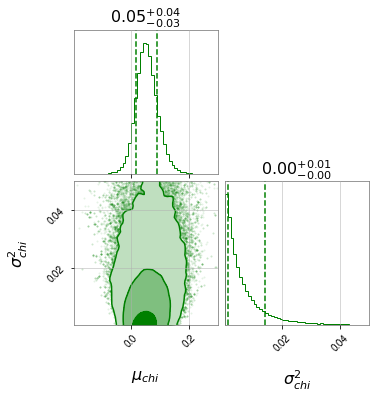

In [52]:
resultB.plot_corner(color='g', range = [(-0.2,0.3), (0, 0.05)])

In [ ]:
resultB = 

### Sampling effective precession spin ($\chi_{\mathrm{p}}$) by parameter estimation

$$\chi_{\mathrm{p}} = max \bigg[a_1sin\theta_1 , \bigg(\frac{4q + 3}{4 + 3q}\bigg)q a_2sin\theta_2\bigg]$$

For each gravitational wave we obtain a set of discrete samples p($\chi_{\mathrm{eff}}$|data) (given by `posterior['chieff']` here)

Effective spins are drawn from a simple truncated Gaussian.

In [ ]:
for posterior in posteriorsB:
    posterior['chi_p'] = chiP(posterior['a_1'], posterior['a_2'],
                              posterior['mass_ratio'], posterior['cos_tilt_1'], posterior['cos_tilt_2'])

###  IGNORE THIS --- Joint mass and redshift model:

$$p_{astro}(m_1, m_2, z) \propto \frac{(1+z)^{1.7}}{m_1(m_1 - M_{min})} \frac{dV_c}{dz}$$

where $m_1$ and $m_2$ are source frame masses.

As a first step, we assume that the underlying mass distribution does not vary across cosmic time, so that we can factor the joint mass-redshift distribution as:

$$p(m_1, m_2, z) = p(m_1, m_2) p(z)$$

This assumption may break down over a large range of redshifts, as many formation scenarios predict some dependence of the mass distribution on the merger redshift. However, LIGO is only sensitive to redshifts z <~ 1.5, for which this is a good approximation. 

<br>

<font color = 'green'>
I am highly skeptical about my implementation of the mass model. Please suggest corrections. Note that this model does not impose a maximum mass cutoff.
</font>

This is the model given in gwpop.models.redshift:

$$p(z|\gamma, \kappa, z_p) \propto \frac{1}{1 + z}\frac{dV_c}{dz} \psi(z|\gamma, \kappa, z_p)$$

$$\psi(z|\gamma, \kappa, z_p) = \frac{(1 + z)^\gamma}{1 + (\frac{1 + z}{1 + z_p})^\kappa}$$

However, I rewrote its simplified version here, (to account for f(z) as in https://arxiv.org/pdf/1805.10270.pdf (9))